In [1]:
# import necessary libraries

import numpy as np
import pandas as pd
import pandas_ta as ta
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# define the ticker of interest

symbol = 'SHEL'
ticker = yf.Ticker(symbol)
start_date = '2007-01-01'
end_date = '2022-01-01'
interval = '1d'
data = ticker.history(start=start_date, end=end_date, interval=interval)

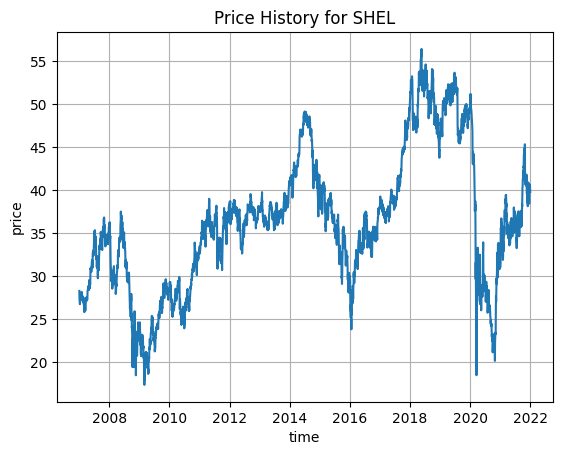

,Open,Close
Date,,
2007-01-03 00:00:00-05:00,28.736587,28.286564
2007-01-04 00:00:00-05:00,28.023040,27.832489
2007-01-05 00:00:00-05:00,27.321648,27.321648
2007-01-08 00:00:00-05:00,27.268941,27.082445
2007-01-09 00:00:00-05:00,26.883784,26.972979
...,...,...
2021-12-27 00:00:00-05:00,40.029803,40.644096
2021-12-28 00:00:00-05:00,40.515727,40.359863
2021-12-29 00:00:00-05:00,40.314022,40.048134


In [3]:
# We only care about 'Open' and 'Close' so we discard the rest of the columns in the OHLCV data

data = data.drop(['Low', 'High', 'Volume', 'Dividends', 'Stock Splits'], axis=1)

# Now we visualize it

fig, ax = plt.subplots()
ax.plot(data['Close'])
ax.grid(True)
ax.set_xlabel('time')
ax.set_ylabel('price')
ax.set_title(f'Price History for {symbol}')
plt.show()
data

In [4]:
# We are interested in feature engineering now
# Construct an exponential moving average of the open-close spread at 3 time scales - fast, medium and slow
# Additionally we lag the open-close time series by -1 to prepare our dataset for predictive training 
# We will use the previous open-close spread time series to predict the next one and use that with the next open price to predict the next close price  
# We also compute a close_price_delta for some mean and standard deviation analysis later

data['period_change'] = data['Close']-data['Open']
data['EMA_Fast'] = ta.ema(data['period_change'], length=13)
data['EMA_Medium'] = ta.ema(data['period_change'], length=26)
data['EMA_Slow'] = ta.ema(data['period_change'], length=39)
data['next_period_change'] = data['period_change'].shift(-1)
data['close_price_delta'] = data['Close'].shift(-1)-data['Close']
data = data.dropna() # the up-shift produced an NA element in the last row so we remove it
data

,Open,Close,period_change,EMA_Fast,EMA_Medium,EMA_Slow,next_period_change,close_price_delta
Date,,,,,,,,
2007-02-28 00:00:00-05:00,27.277049,26.609859,-0.667190,-0.140414,-0.065379,-0.006354,0.437972,0.282431
2007-03-01 00:00:00-05:00,26.454318,26.892290,0.437972,-0.057788,-0.028094,0.015862,-0.196475,-0.613968
2007-03-02 00:00:00-05:00,26.474797,26.278322,-0.196475,-0.077600,-0.040567,0.005245,0.151449,-0.458443
2007-03-05 00:00:00-05:00,25.668430,25.819880,0.151449,-0.044879,-0.026343,0.012556,0.171913,0.536205
2007-03-06 00:00:00-05:00,26.184171,26.356085,0.171913,-0.013908,-0.011658,0.020523,0.450251,0.356117
...,...,...,...,...,...,...,...,...
2021-12-23 00:00:00-05:00,40.341528,40.194832,-0.146696,0.026933,-0.019170,-0.029428,0.614293,0.449265
2021-12-27 00:00:00-05:00,40.029803,40.644096,0.614293,0.110842,0.027753,0.002758,-0.155863,-0.284233
2021-12-28 00:00:00-05:00,40.515727,40.359863,-0.155863,0.072741,0.014152,-0.005173,-0.265888,-0.311729


In [5]:
features = ['period_change', 'EMA_Fast', 'EMA_Medium', 'EMA_Slow']
target = ['next_period_change']

X_scaler = MinMaxScaler(feature_range=(0,1)) # one scaler for the feature data
y_scaler = MinMaxScaler(feature_range=(0,1)) # one scaler for the target open-close spreads
transformed_data = pd.DataFrame(X_scaler.fit_transform(data[features]), columns=features, index=data.index) # fit the scaler to the features
transformed_data[target] = y_scaler.fit_transform(data[target]) # fit the scaler to the targets
transformed_data

,period_change,EMA_Fast,EMA_Medium,EMA_Slow,next_period_change
Date,,,,,
2007-02-28 00:00:00-05:00,0.367958,0.527480,0.593166,0.676923,0.642945
2007-03-01 00:00:00-05:00,0.642945,0.582151,0.630602,0.706894,0.485082
2007-03-02 00:00:00-05:00,0.485082,0.569042,0.618079,0.692571,0.571652
2007-03-05 00:00:00-05:00,0.571652,0.590693,0.632360,0.702433,0.576744
2007-03-06 00:00:00-05:00,0.576744,0.611185,0.647105,0.713182,0.646000
...,...,...,...,...,...
2021-12-23 00:00:00-05:00,0.497468,0.638209,0.639562,0.645796,0.686818
2021-12-27 00:00:00-05:00,0.686818,0.693729,0.686675,0.689216,0.495187
2021-12-28 00:00:00-05:00,0.495187,0.668518,0.673019,0.678517,0.467810


In [6]:
num_examples = transformed_data.shape[0] # number of successive differences we have
n_features = len(features) # number of features 
lookback_period = 30 # the history look-back period to base predictions on

X = transformed_data[features].to_numpy() # convert to numpy
y = transformed_data[target].to_numpy() # convert to numpy

# Now we need to format the data for the LSTM based on the look-back period
# The X data must be of shape (None, lookback_period, n_features) where None represents the number of training examples of sequence-length lookback_period
# The y data must be of shape (None, 1)

X_list = []
y_list = []
for i in range(lookback_period, num_examples+1): # for all the sequences of size lookback period
    X_list.append(X[i-lookback_period:i]) # add minibatches of size look-back period to the X data, one for each run sequence
    y_list.append(y[i-1]) # add the corresponding future value to be predicted

X = np.array(X_list) # convert to numpy
y = np.array(y_list) # convert to numpy

print(X.shape)
print(y.shape)

(3709, 30, 4)
(3709, 1)


In [7]:
# Define the model here

# one input layer, two LSTM layers, one dense layer 
def create_model(): # returns the network model
    input = tf.keras.Input(shape=(lookback_period, n_features))
    X = tf.keras.layers.LSTM(units=150, return_sequences=True)(input)
    X = tf.keras.layers.LSTM(units=20, return_sequences=False)(input)
    X = tf.keras.layers.Dense(units=1)(X)
    model = tf.keras.Model(inputs=input, outputs=X)
    return model

model = 2
model = create_model()
model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=tf.keras.metrics.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(1e-4)) # choose the loss, metrics and optimizer
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 4)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 20)                2000      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 2021 (7.89 KB)
Trainable params: 2021 (7.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# Now we backtest

true_close_prices = data['Close'].iloc[lookback_period-1:].to_numpy() # the true close prices (that we tried to predict) we know in hindsight for this historical data
true_next_changes = data['close_price_delta'].to_numpy()
z_score_multiplier = 1 # 0 for no trades, higher values for more daring trades

def backtest(initial_balance):
    balance = initial_balance # define the working balance
    portfolio_value = initial_balance # the total value of assets held + cash balance
    portfolio_values = [] # a list containing portfolio value for each timestep 
    shares_held = [] # a list containing the number of shares held at each timestep
    balances = [] # a list containing the working balance at each timestep
    max_shares = 10 # the maximum number of shares tradeable (buy/sell) in one timestep
    shares = 0 # the initial number of shares held is 0
    stock_price = true_close_prices[0]  # the initial price is the close price (note that all buys and sells will occur at the last known close price)
    predicted_close_prices = [] # a list containing the predicted close prices at each timestep
    next_change_predictions = [] # a list containing the next open-close spread prediction at each timestep
    mean = 0 # the mean of the predicted open-close spreads
    std = 0 # the standard deviation of the open-close spreads

    z_score = 0
    for i in range(0, len(true_close_prices)): # for each timestep
        print(f"Timestep{i}")
        stock_price = true_close_prices[i] # update stock price at the start of the timestep

        # close the previous order
        shares -= 2*(norm.cdf(z_score, loc=0, scale=1)-0.5)*max_shares
        balance += 2*(norm.cdf(z_score, loc=0, scale=1)-0.5)*max_shares*stock_price

        next_change_prediction = model.predict(X[i:i+1]) # predict on one X input (pass in with shape (1, lookback_period, num_features))
        next_change_prediction = y_scaler.inverse_transform(next_change_prediction).reshape(-1) # we need to reverse the scaling transform to get change predictions at the real world scale
        next_change_predictions.append(next_change_prediction) # add to list

        mean = np.mean(true_next_changes[max(0, i-1):i+lookback_period-1]) # compute the mean of the true closing price differentials over the last lookback period
        std = np.std(true_next_changes[max(0, i-1):i+lookback_period-1]) # compute the standard deviation of the true closing price differentials over the last lookback period

        if i != len(true_close_prices)-1: # if not the last datapoint (because we don't have the last open price (we used dropna()) to predict the last closing price)
            predicted_close_price = data['Open'].iloc[lookback_period+i] + next_change_prediction # calculate the next close price
            
            predicted_close_prices.append(predicted_close_price) # add to list

            z_score = z_score_multiplier*(((predicted_close_price- stock_price) - mean)/std)[0] # assuming the change in closing prices to be distributed normally with mean and standard deviation estimated as above, compute the z_score
            shares += 2*(norm.cdf(z_score, loc=0, scale=1)-0.5)*max_shares # use the normal cdf and z_score to map to a value between -max_shares and +max_shares 
            balance -= 2*(norm.cdf(z_score, loc=0, scale=1)-0.5)*max_shares*stock_price # update the balance based on shares bought or sold

            model.fit(X[i:i+1], y[i:i+1], epochs=1) # train on the next X-y example

        portfolio_value = balance + shares*stock_price # update portfolio
        portfolio_values.append(portfolio_value) # add to list
        balances.append(balance) # add to list
        shares_held.append(shares) # add to list 
    return portfolio_values, balances, shares_held, predicted_close_prices # return the time series lists

initial_balance = 10000
portfolio_values, balances, shares_held, predicted_close_prices = backtest(initial_balance)

Timestep0
1/1 [==============================] - 1s 1s/step - loss: 0.3518 - mean_squared_error: 0.3518
Timestep1
1/1 [==============================] - 0s 7ms/step - loss: 0.3159 - mean_squared_error: 0.3159
Timestep2
1/1 [==============================] - 0s 8ms/step - loss: 0.2753 - mean_squared_error: 0.2753
Timestep3
1/1 [==============================] - 0s 8ms/step - loss: 0.2569 - mean_squared_error: 0.2569
Timestep4
1/1 [==============================] - 0s 8ms/step - loss: 0.2695 - mean_squared_error: 0.2695
Timestep5
1/1 [==============================] - 0s 9ms/step - loss: 0.2797 - mean_squared_error: 0.2797
Timestep6
1/1 [==============================] - 0s 8ms/step - loss: 0.3011 - mean_squared_error: 0.3011
Timestep7
1/1 [==============================] - 0s 9ms/step - loss: 0.2454 - mean_squared_error: 0.2454
Timestep8
1/1 [==============================] - 0s 8ms/step - loss: 0.1948 - mean_squared_error: 0.1948
Timestep9
1/1 [==============================] - 0s 9ms/

final shares held = 0.0
final balance = 17502.197000684646
returns = 75.02 %


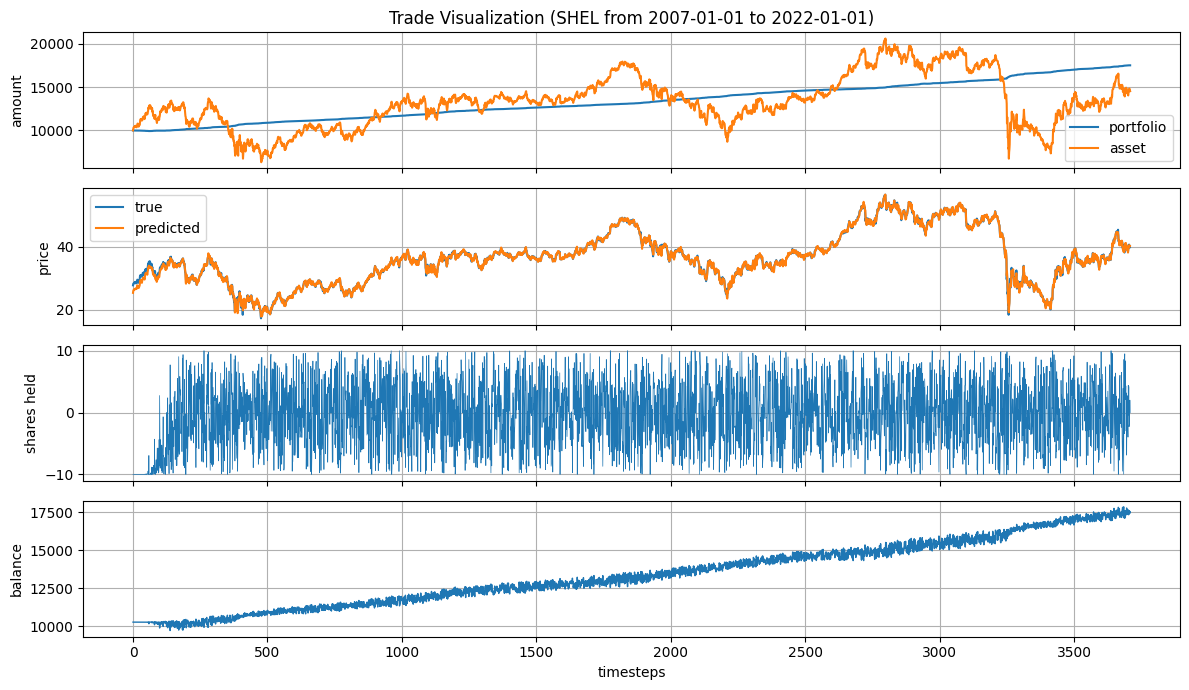

In [9]:
print(f"final shares held = {shares_held[-1]}")
print(f"final balance = {balances[-1]}")
print("returns = %.2f %%" % ((balances[-1]/initial_balance-1)*100))

# Now let's visualize the trade
fig, axs = plt.subplots(4, 1, figsize=(12, 7), sharex=True)

axs[0].plot(portfolio_values, label='portfolio')
axs[0].plot((true_close_prices/true_close_prices[0])*initial_balance, label='asset')
axs[0].set_ylabel('amount')
axs[0].grid(True)
axs[0].legend(loc='lower right')
axs[0].set_title(f'Trade Visualization ({symbol} from {start_date} to {end_date})')

axs[1].plot(true_close_prices[1:], label='true')
axs[1].plot(predicted_close_prices, label='predicted')
axs[1].set_ylabel('price')
axs[1].grid(True)
axs[1].legend()

axs[2].plot(shares_held, lw=0.5)
axs[2].set_ylabel('shares held')
axs[2].grid(True)

axs[3].plot(balances, lw=1)
axs[3].set_ylabel('balance')
axs[3].set_xlabel('timesteps')
axs[3].grid(True)

plt.tight_layout()
plt.show()



In [10]:
# Note that the strategy is position-neutral at the end of the trade